# **1. Notebook Setup**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from datetime import datetime
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 120)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
os.makedirs("outputs/charts", exist_ok=True)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thousand-ml-jobs-in-usa/1000_ml_jobs_us.csv


# **2. Load the dataset**

In [2]:
# change path to your file
df = pd.read_csv("/kaggle/input/thousand-ml-jobs-in-usa/1000_ml_jobs_us.csv")

print(df.shape)
df.head()


(997, 10)


,Unnamed: 0,job_posted_date,company_address_locality,company_address_region,company_name,company_website,company_description,job_description_text,seniority_level,job_title
0,0,2024-10-31,Indianapolis,Indiana,Upper Hand,https://upperhand.com,Upper Hand is the leading provider of full-suite sports management software that enable businesses to achieve more w...,"OverviewUpper Hand is embarking on an exciting journey to harness the power of machine learning, data science, and A...",Internship,Internship - Machine Learning Engineer & Data Science
1,1,2025-03-14,San Francisco,California,Ikigai,https://www.ikigailabs.io,"Built upon years of MIT research, Ikigai is a generative AI platform for tabular and time series data. It helps oper...",Company DescriptionThe Ikigai platform unlocks the power of generative AI for tabular data. We enable business users...,Mid-Senior level,Machine Learning Engineer
2,2,2025-04-09,San Jose,CA,Adobe,http://www.adobe.com,"Adobe is the global leader in digital media and digital marketing solutions. Our creative, marketing and document so...",Our CompanyChanging the world through digital experiences is what Adobe’s all about. We give everyone—from emerging ...,Entry level,Machine Learning Engineer
3,3,2025-03-22,Mountain View,California,Waymo,https://waymo.com/careers/,"On the journey to be the world's most trusted driver. With the Waymo Driver, we can improve mobility while saving th...",Waymo is an autonomous driving technology company with the mission to be the most trusted driver. Since its start as...,Entry level,"Machine Learning Engineer, Training"
4,4,2025-03-28,Boston,Massachusetts,HMH,http://www.hmhco.com,"We are an adaptive learning company that empowers educators. With a focus on what moves each learner, HMH delivers w...",Job Title: Machine Learning EngineerLocation: RemoteWho We AreNWEA® is a division of Houghton Mifflin Harcourt that ...,Mid-Senior level,Machine Learning Engineer


**2.1 Quick structure check**

In [3]:
df.info()
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                997 non-null    int64 
 1   job_posted_date           997 non-null    object
 2   company_address_locality  950 non-null    object
 3   company_address_region    884 non-null    object
 4   company_name              997 non-null    object
 5   company_website           983 non-null    object
 6   company_description       985 non-null    object
 7   job_description_text      996 non-null    object
 8   seniority_level           988 non-null    object
 9   job_title                 997 non-null    object
dtypes: int64(1), object(9)
memory usage: 78.0+ KB


company_address_region      113
company_address_locality     47
company_website              14
company_description          12
seniority_level               9
job_description_text          1
job_posted_date               0
Unnamed: 0                    0
company_name                  0
job_title                     0
dtype: int64

**2.2. Remove duplicates**

In [4]:
df.duplicated().sum()
df = df.drop_duplicates()

# also check duplicates by title + company + description
dup_key = ["company_name", "job_title", "job_description_text"]
df.duplicated(subset=dup_key).sum()
df = df.drop_duplicates(subset=dup_key)

print(df.shape)


(801, 10)


**2.3. Standardize column names**

In [5]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)
df.columns


Index(['unnamed:_0', 'job_posted_date', 'company_address_locality',
       'company_address_region', 'company_name', 'company_website',
       'company_description', 'job_description_text', 'seniority_level',
       'job_title'],
      dtype='object')

**2.4. Parse dates + basic cleaning**

In [6]:
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"], errors="coerce")

# standardize text columns
text_cols = ["company_name", "company_address_locality", "company_address_region", "seniority_level", "job_title"]
for c in text_cols:
    df[c] = df[c].astype(str).str.strip()

df["company_address_region"] = df["company_address_region"].str.upper().str.strip()


In [7]:
df["job_posted_date"].min(), df["job_posted_date"].max()
df["company_address_region"].value_counts().head(10)
df["seniority_level"].value_counts()


seniority_level
Mid-Senior level    314
Entry level         254
Not Applicable      130
Internship           62
Associate            27
nan                   9
Director              4
Executive             1
Name: count, dtype: int64

**2.5. Clean job description text**

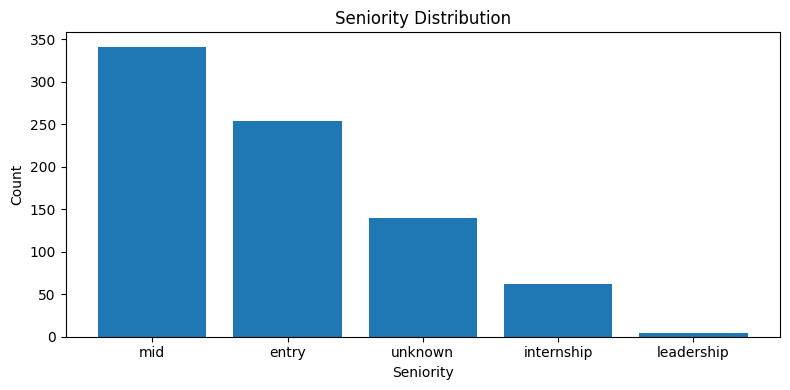

In [10]:
sen = df["seniority_norm"].value_counts()

plt.figure(figsize=(8,4))
plt.bar(sen.index, sen.values)
plt.title("Seniority Distribution")
plt.xlabel("Seniority")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("outputs/charts/Seniority_Distribution1.png", dpi=200, bbox_inches="tight")
plt.show()


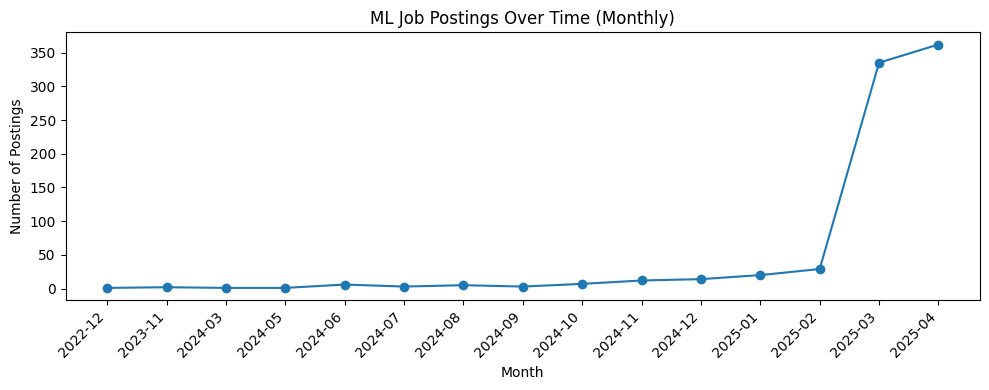

In [11]:
tmp = df.dropna(subset=["job_posted_date"]).copy()
monthly = tmp.groupby(tmp["job_posted_date"].dt.to_period("M")).size().sort_index()
monthly.index = monthly.index.astype(str)

plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("ML Job Postings Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of Postings")
plt.tight_layout()
plt.savefig("outputs/charts/ML job Posting Over Tine(Monthly).png", dpi=200, bbox_inches="tight")
plt.show()


**2.6. Clean job description text**

In [12]:
def clean_text(t: str) -> str:
    if pd.isna(t):
        return ""
    t = str(t)
    t = t.lower()
    t = re.sub(r"\s+", " ", t)                # multiple spaces
    t = re.sub(r"http\S+|www\.\S+", " ", t)   # remove links
    t = re.sub(r"[^a-z0-9\+\#\.\-\s]", " ", t) # keep useful symbols like +, #, ., -
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["job_description_clean"] = df["job_description_text"].apply(clean_text)

df[["job_title", "job_description_clean"]].head(3)


,job_title,job_description_clean
0,Internship - Machine Learning Engineer & Data Science,overviewupper hand is embarking on an exciting journey to harness the power of machine learning data science and ai ...
1,Machine Learning Engineer,company descriptionthe ikigai platform unlocks the power of generative ai for tabular data. we enable business users...
2,Machine Learning Engineer,our companychanging the world through digital experiences is what adobe s all about. we give everyone from emerging ...


In [13]:
(df["job_description_clean"].str.len() == 0).sum()

np.int64(1)

In [14]:
df = df[df["job_description_clean"].str.len() > 0].copy()
print(df.shape)

(800, 12)


**2.7. Fix seniority values (scraped data = messy)**

In [9]:
def normalize_seniority(x):
    x = str(x).lower()
    if "intern" in x:
        return "internship"
    if "entry" in x or "junior" in x:
        return "entry"
    if "mid" in x or "associate" in x:
        return "mid"
    if "senior" in x or "lead" in x or "staff" in x or "principal" in x:
        return "senior"
    if "director" in x or "head" in x or "vp" in x:
        return "leadership"
    return "unknown"

df["seniority_norm"] = df["seniority_level"].apply(normalize_seniority)
df["seniority_norm"].value_counts()

seniority_norm
mid           341
entry         254
unknown       140
internship     62
leadership      4
Name: count, dtype: int64

**2.8. Basic EDA (to understand the data)**

In [15]:
df["company_address_region"].value_counts().head(15)


company_address_region
CALIFORNIA       234
CA               134
NAN               98
NY                31
MASSACHUSETTS     20
WA                18
TEXAS             18
NEW YORK          17
FLORIDA           15
ENGLAND           13
MA                11
NJ                 9
LONDON             9
VIRGINIA           8
WASHINGTON         7
Name: count, dtype: int64

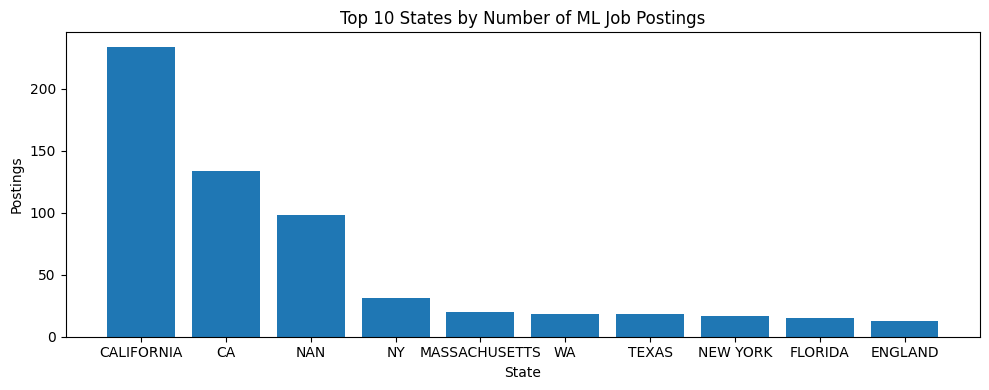

In [16]:
top_states = df["company_address_region"].value_counts().head(10)

plt.figure(figsize=(10,4))
plt.bar(top_states.index, top_states.values)
plt.title("Top 10 States by Number of ML Job Postings")
plt.xlabel("State")
plt.ylabel("Postings")
plt.tight_layout()
plt.savefig("outputs/charts/Top 10 States by Number of ML Job Postings.png", dpi=200, bbox_inches="tight")
plt.show()


In [17]:
df["job_title"].value_counts().head(15)


job_title
Machine Learning Engineer                   215
Data Scientist                               38
Senior Machine Learning Engineer             22
Software Engineer, Machine Learning          10
Machine Learning Engineer II                  8
Software Engineer                             7
Machine Learning Engineer III                 4
Machine Learning Engineer, Ads Targeting      4
AI Software Engineer                          4
AI/ML Software Engineer                       4
Software Engineer - Machine Learning          3
Machine Learning Research Engineer            3
Software Engineer - Onboarding                3
AI/Machine Learning Engineer                  3
Machine Learning Data Engineer                2
Name: count, dtype: int64

In [18]:
df.groupby(df["job_posted_date"].dt.to_period("M")).size().sort_index()


job_posted_date
2022-12      1
2023-11      2
2024-03      1
2024-05      1
2024-06      6
2024-07      3
2024-08      5
2024-09      3
2024-10      7
2024-11     12
2024-12     14
2025-01     20
2025-02     29
2025-03    335
2025-04    361
Freq: M, dtype: int64

**2.9. Save a cleaned version**

In [19]:
df.to_csv("ml_jobs_cleaned.csv", index=False)


# **3. NLP**

**Define the NLP Objective**

**3.1. Objective**

Extract technical skills and tools from machine learning job descriptions using NLP techniques in order to analyze skill demand by seniority, location, and role.

**3.2 Create a Skill Dictionary**

In [20]:
SKILLS = {
    "programming": [
        "python", "r", "java", "scala", "c++"
    ],
    "data": [
        "sql", "nosql", "pandas", "numpy", "spark", "hadoop"
    ],
    "ml_frameworks": [
        "scikit-learn", "sklearn", "tensorflow", "pytorch", "xgboost", "lightgbm"
    ],
    "deep_learning": [
        "neural networks", "cnn", "rnn", "lstm", "transformers"
    ],
    "nlp": [
        "nlp", "bert", "llm", "gpt", "spacy", "nltk"
    ],
    "ml_ops": [
        "mlops", "docker", "kubernetes", "airflow", "ci/cd"
    ],
    "cloud": [
        "aws", "gcp", "azure", "sagemaker"
    ],
    "math": [
        "statistics", "probability", "linear algebra", "optimization"
    ]
}


**3.3. Flatten Skill Dictionary**

In [21]:
skill_list = []
for category, skills in SKILLS.items():
    for skill in skills:
        skill_list.append((category, skill))

skill_list[:10]


[('programming', 'python'),
 ('programming', 'r'),
 ('programming', 'java'),
 ('programming', 'scala'),
 ('programming', 'c++'),
 ('data', 'sql'),
 ('data', 'nosql'),
 ('data', 'pandas'),
 ('data', 'numpy'),
 ('data', 'spark')]

**3.4. Skill Matching Function (regex-based NLP)**

In [22]:
def extract_skills(text):
    found_skills = []
    for category, skill in skill_list:
        pattern = rf"\b{re.escape(skill)}\b"
        if re.search(pattern, text):
            found_skills.append((category, skill))
    return found_skills


**3.5. Apply Skill Extraction to Dataset**

In [23]:
df["skills_extracted"] = df["job_description_clean"].apply(extract_skills)
df[["job_title", "skills_extracted"]].head(5)


,job_title,skills_extracted
0,Internship - Machine Learning Engineer & Data Science,"[(programming, python), (programming, r), (data, sql), (data, pandas), (data, spark), (ml_frameworks, pytorch), (clo..."
1,Machine Learning Engineer,"[(programming, python), (data, spark), (data, hadoop), (ml_frameworks, tensorflow), (ml_frameworks, pytorch), (ml_op..."
2,Machine Learning Engineer,"[(programming, python), (programming, scala), (ml_frameworks, pytorch), (deep_learning, transformers), (nlp, nlp), (..."
3,"Machine Learning Engineer, Training","[(programming, python), (ml_frameworks, tensorflow), (ml_frameworks, pytorch), (deep_learning, neural networks), (cl..."
4,Machine Learning Engineer,"[(programming, python), (programming, r), (data, sql), (data, spark), (ml_frameworks, tensorflow), (ml_frameworks, p..."


In [24]:
df.iloc[0]["job_description_clean"][:500]
df.iloc[0]["skills_extracted"]


[('programming', 'python'),
 ('programming', 'r'),
 ('data', 'sql'),
 ('data', 'pandas'),
 ('data', 'spark'),
 ('ml_frameworks', 'pytorch'),
 ('cloud', 'aws'),
 ('cloud', 'gcp'),
 ('cloud', 'azure'),
 ('math', 'statistics')]

**3.6. Convert Skills into a Structured Table**

Create a long-format skill table

In [25]:
rows = []

for idx, row in df.iterrows():
    for category, skill in row["skills_extracted"]:
        rows.append({
            "job_id": idx,
            "company": row["company_name"],
            "job_title": row["job_title"],
            "seniority": row["seniority_norm"],
            "state": row["company_address_region"],
            "skill_category": category,
            "skill": skill
        })

skills_df = pd.DataFrame(rows)
skills_df.head()


,job_id,company,job_title,seniority,state,skill_category,skill
0,0,Upper Hand,Internship - Machine Learning Engineer & Data Science,internship,INDIANA,programming,python
1,0,Upper Hand,Internship - Machine Learning Engineer & Data Science,internship,INDIANA,programming,r
2,0,Upper Hand,Internship - Machine Learning Engineer & Data Science,internship,INDIANA,data,sql
3,0,Upper Hand,Internship - Machine Learning Engineer & Data Science,internship,INDIANA,data,pandas
4,0,Upper Hand,Internship - Machine Learning Engineer & Data Science,internship,INDIANA,data,spark


**3.7. Skill Frequency Analysis**

**Top skills overall**

In [26]:
skills_df["skill"].value_counts().head(15)


skill
python          579
pytorch         344
tensorflow      281
aws             235
optimization    203
sql             194
statistics      173
spark           159
nlp             159
llm             142
gcp             123
azure           122
java            115
mlops           108
r               105
Name: count, dtype: int64

**Top skill categories**

In [27]:
skills_df["skill_category"].value_counts()


skill_category
programming      848
ml_frameworks    769
data             553
cloud            516
math             400
nlp              367
ml_ops           333
deep_learning    120
Name: count, dtype: int64

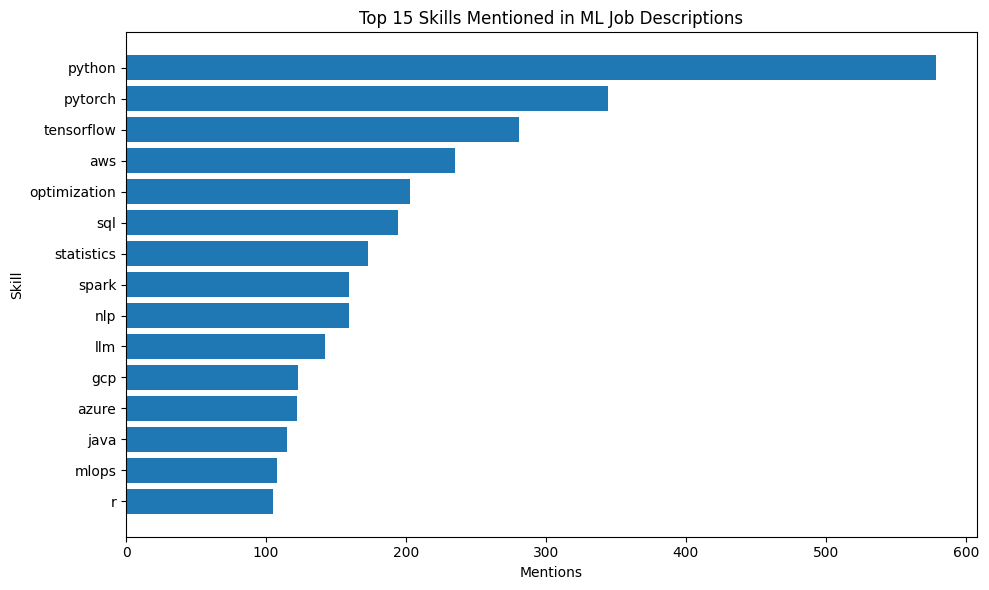

In [28]:
top_skills = skills_df["skill"].value_counts().head(15)[::-1]  # reverse for nice ordering

plt.figure(figsize=(10,6))
plt.barh(top_skills.index, top_skills.values)
plt.title("Top 15 Skills Mentioned in ML Job Descriptions")
plt.xlabel("Mentions")
plt.ylabel("Skill")
plt.tight_layout()
plt.savefig("outputs/charts/Top 15 Skills Mentioned in ML Job Descriptions.png", dpi=200, bbox_inches="tight")
plt.show()


**3.9. Skills by State**

In [29]:
skills_df.groupby(["state", "skill"]) \
         .size() \
         .reset_index(name="count") \
         .sort_values("count", ascending=False) \
         .head(20)


,state,skill,count
137,CALIFORNIA,python,150
98,CA,python,101
138,CALIFORNIA,pytorch,92
148,CALIFORNIA,tensorflow,80
612,NAN,python,77
134,CALIFORNIA,optimization,67
99,CA,pytorch,57
130,CALIFORNIA,nlp,56
145,CALIFORNIA,spark,54
147,CALIFORNIA,statistics,52


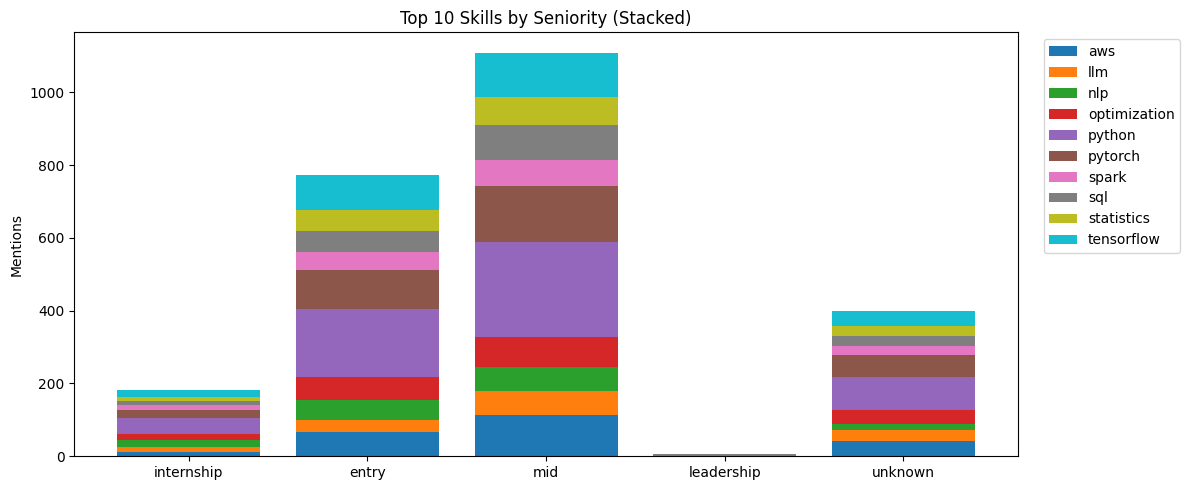

In [30]:
topN = 10
top_skill_names = skills_df["skill"].value_counts().head(topN).index

pivot = (skills_df[skills_df["skill"].isin(top_skill_names)]
         .groupby(["seniority", "skill"])
         .size()
         .unstack(fill_value=0))

# Make sure seniority order is logical
order = ["internship", "entry", "mid", "senior", "leadership", "unknown"]
pivot = pivot.reindex([x for x in order if x in pivot.index])

plt.figure(figsize=(12,5))
bottom = np.zeros(len(pivot))
x = np.arange(len(pivot.index))

for skill in pivot.columns:
    plt.bar(x, pivot[skill].values, bottom=bottom, label=skill)
    bottom += pivot[skill].values

plt.title(f"Top {topN} Skills by Seniority (Stacked)")
plt.xticks(x, pivot.index, rotation=0)
plt.ylabel("Mentions")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("outputs/charts/Top 10 Skills by Seniority (Stacked).png", dpi=200, bbox_inches="tight")
plt.show()


**3.8. Skills by Seniority**

In [31]:
pd.crosstab(
    skills_df["seniority"],
    skills_df["skill"],
    normalize="index"
).round(2).iloc[:, :10]


skill,airflow,aws,azure,bert,c++,cnn,docker,gcp,gpt,hadoop
seniority,,,,,,,,,,
entry,0.01,0.06,0.02,0.01,0.00,0.00,0.01,0.02,0.01,0.01
internship,0.01,0.04,0.03,0.01,0.01,0.01,0.01,0.03,0.01,0.03
leadership,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mid,0.01,0.06,0.04,0.00,0.00,0.00,0.03,0.04,0.01,0.01
unknown,0.01,0.07,0.03,0.00,0.00,0.00,0.02,0.04,0.01,0.01


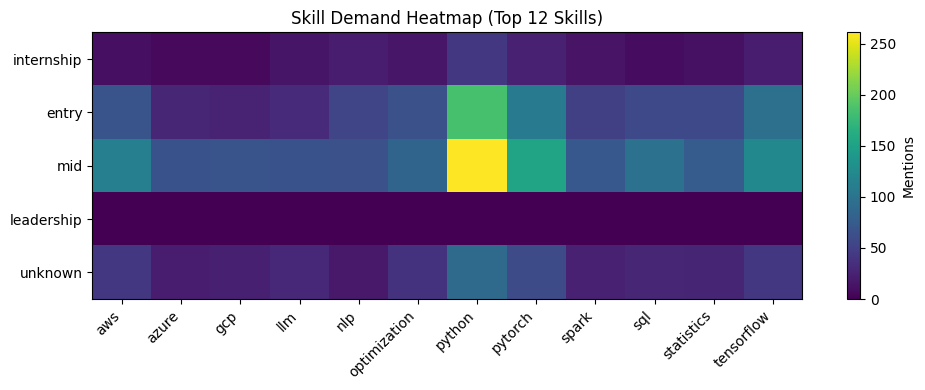

In [32]:
topN = 12
top_skill_names = skills_df["skill"].value_counts().head(topN).index

heat = (skills_df[skills_df["skill"].isin(top_skill_names)]
        .groupby(["seniority", "skill"])
        .size()
        .unstack(fill_value=0))

order = ["internship", "entry", "mid", "senior", "leadership", "unknown"]
heat = heat.reindex([x for x in order if x in heat.index])

plt.figure(figsize=(10,4))
plt.imshow(heat.values, aspect="auto")
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha="right")
plt.yticks(range(len(heat.index)), heat.index)
plt.title(f"Skill Demand Heatmap (Top {topN} Skills)")
plt.colorbar(label="Mentions")
plt.tight_layout()
plt.savefig("outputs/charts/Skill Demand Heatmap (Top 10 Skills).png", dpi=200, bbox_inches="tight")
plt.show()


# **4. Seniority Prediction from Job Descriptions**

Before modeling, make sure these columns exist:

In [33]:
required_cols = ["job_description_clean", "seniority_norm"]
missing = [c for c in required_cols if c not in df.columns]
missing

[]

**2. Define the modeling dataset (filter + target cleanup)**

Unknown, leadership, internship are noisy and will hurt the model.

In [34]:
df_model = df[df["seniority_norm"].isin(["entry", "mid", "senior"])].copy()

df_model["seniority_norm"].value_counts()


seniority_norm
mid      341
entry    254
Name: count, dtype: int64

remove empty text:

In [35]:
df_model = df_model[df_model["job_description_clean"].str.len() > 50].copy()
df_model.shape


(595, 13)

**3. Train/test split (stratified)**

In [36]:
from sklearn.model_selection import train_test_split

X_text = df_model["job_description_clean"]
y = df_model["seniority_norm"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


**4. Baseline model**

This gives you a "mininmum" to beat

**4.1 Vectorize with TF-IDF**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),
    stop_words="english",
    min_df=2
)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)


**4.2 Train Logistic Regression**

In [38]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=2000, n_jobs=-1)

**5. Evaluate**

**5.1 Classification report**

In [39]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       entry       0.68      0.29      0.41        51
         mid       0.63      0.90      0.74        68

    accuracy                           0.64       119
   macro avg       0.66      0.60      0.58       119
weighted avg       0.65      0.64      0.60       119



**5.2 Confusion matrix (matplotlib)**

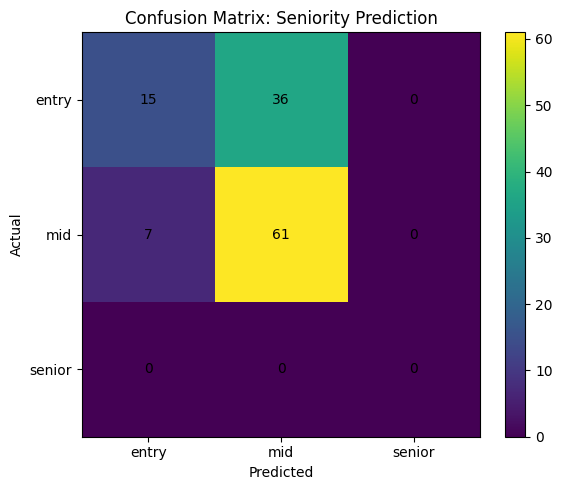

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

labels = ["entry", "mid", "senior"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, aspect="auto")
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
plt.title("Confusion Matrix: Seniority Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


**6. Error analysis**

**6.1 Find wrong predictions**

In [42]:
test_df = pd.DataFrame({
    "text": X_test_text.values,
    "true": y_test.values,
    "pred": y_pred
})

errors = test_df[test_df["true"] != test_df["pred"]].copy()
errors.head(10)


,text,true,pred
1,snap inc is a technology company. we believe the camera presents the greatest opportunity to improve the way people ...,mid,entry
4,xpeng is a leading smart technology company at the forefront of innovation integrating advanced ai and autonomous dr...,entry,mid
5,overviewcome build community explore your passions and do your best work at microsoft. this opportunity will allow y...,entry,mid
7,company overviewcohere health is a fast-growing clinical intelligence company that s improving lives at scale by pro...,entry,mid
9,perplexity is seeking experienced applied ai amp ml engineers to help build next generation of personalization exper...,entry,mid
13,magnit direct sourcing on behalf of toyota is currently hiring for a machine learning engineer role for a temporary ...,entry,mid
15,machine learning engineerslocation austin tx w2 contract only no c2c c2h job description.minimum 6-8 years of experi...,entry,mid
19,at buildops we re building a groundbreaking software solution designed to support today s commercial contractors. fr...,entry,mid
20,responsibilitiestiktok is the leading destination for short-form mobile video. our mission is to inspire creativity ...,mid,entry
21,position summarysamsung ads is a rapidly growing advanced advertising technology company that focuses on enabling ad...,entry,mid


**6.2 Show examples of key confusions**

In [43]:
errors[(errors["true"]=="senior") & (errors["pred"]=="mid")].head(5)


,text,true,pred


**7. Make the model explainable**

In [44]:
feature_names = np.array(tfidf.get_feature_names_out())

for i, cls in enumerate(clf.classes_):
    top = np.argsort(clf.coef_[i])[-20:]
    print(f"\nTop terms for class: {cls}")
    print(feature_names[top])



Top terms for class: entry
['teams' 'distributed' 'azure' 'modeling' 'systems' 'critical' 'llms'
 'airbnb' 'pinterest' 'engineering' 'senior machine' 'nextdoor' 'non'
 'amd' 'gcp' 'ml' 'generative ai' 'llm' 'amp' 'ai']


IndexError: index 1 is out of bounds for axis 0 with size 1

**8. Some Upgrades**

In [45]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print(classification_report(y_test, svm_pred))


              precision    recall  f1-score   support

       entry       0.59      0.47      0.52        51
         mid       0.65      0.75      0.70        68

    accuracy                           0.63       119
   macro avg       0.62      0.61      0.61       119
weighted avg       0.62      0.63      0.62       119



In [46]:
clf_w = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
clf_w.fit(X_train, y_train)
pred_w = clf_w.predict(X_test)

print(classification_report(y_test, pred_w))


              precision    recall  f1-score   support

       entry       0.57      0.39      0.47        51
         mid       0.63      0.78      0.70        68

    accuracy                           0.61       119
   macro avg       0.60      0.59      0.58       119
weighted avg       0.61      0.61      0.60       119



In [47]:
def predict_seniority(description: str):
    text = description.lower()
    X_new = tfidf.transform([text])
    return clf.predict(X_new)[0]

predict_seniority("We are looking for an ML engineer with strong python, sql, and good fundamentals in ML...")


'mid'

In [48]:
import joblib

joblib.dump(tfidf, "tfidf.joblib")
joblib.dump(clf, "seniority_model.joblib")


['seniority_model.joblib']

In [49]:
import os
os.listdir("/kaggle/working")


['.virtual_documents',
 'ml_jobs_cleaned.csv',
 'outputs',
 'seniority_model.joblib',
 'tfidf.joblib']

# 6. Conclusion

**Model Selection Conclusion**

* Linear SVM selected as final model

* Optimizes macro F1-score

* Better balance between entry and mid predictions

* More robust to class imbalance in text data